In [1]:
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import tqdm.auto as tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

sns.set_style(style="darkgrid")
plt.rcParams.update({'font.size': 15})
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms as T

In [3]:
device = 'cuda' if torch.cuda.is_available() else ('mps' if torch.mps.is_available() else 'cpu')
device

'mps'

In [10]:
transform = T.Compose([
    T.ToTensor(),
    # T.Resize((32, 32)),
    T.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(
    'MNIST',
    train=True,
    download=True,
    transform=transform
)

val_dataset = torchvision.datasets.MNIST(
    'MNIST',
    train=False,
    download=True,
    transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True, pin_memory=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=1024, shuffle=False, pin_memory=True
)

100%|██████████| 9.91M/9.91M [00:03<00:00, 2.78MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 93.9kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.34MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.18MB/s]


In [11]:
image, label = next(iter(train_loader))

In [12]:
image.shape, label.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

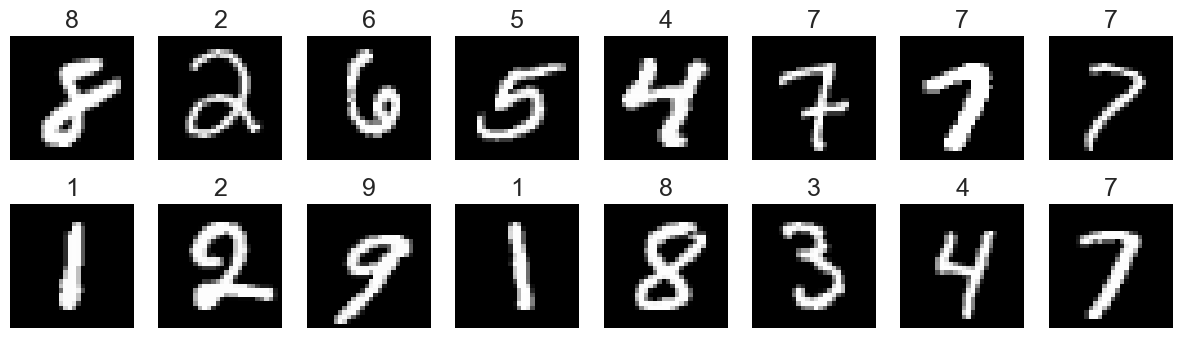

In [13]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
k = 0

for i in range(cols):
    for j in range(rows):
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(np.transpose(image[k], (1, 2, 0)), cmap='gray')
        ax.set_title(label[k].item())
        k += 1

plt.show()

In [14]:
def train_epoch(model, optimizer, criterion):
    loss_log, acc_log = [], []

    model.train()
    for batch_num, (batch_image, batch_label) in enumerate(train_loader):
        batch_image = batch_image.to(device, non_blocking=True)
        batch_label = batch_label.to(device, non_blocking=True)

        optimizer.zero_grad()

        logits = model(batch_image)

        loss = criterion(logits, batch_label)
        loss.backward()
        optimizer.step()

        loss_log.append(loss.item())

        pred = torch.max(logits, dim=1)[1].data.cpu().numpy()
        acc = np.mean(pred == batch_label.data.cpu().numpy())
        acc_log.append(acc)

    return loss_log,  acc_log

In [15]:
def test_epoch(model, criterion):
    loss_log, acc_log = [], []

    model.eval()
    for batch_num, (batch_image, batch_label) in enumerate(val_loader):
        batch_image = batch_image.to(device, non_blocking=True)
        batch_label = batch_label.to(device, non_blocking=True)

        with torch.no_grad():
            logits = model(batch_image)
            loss = criterion(logits, batch_label)

        pred = torch.max(logits, dim=1)[1].data.cpu().numpy()
        acc = np.mean(pred == batch_label.data.cpu().numpy())
        acc_log.append(acc)

        loss = loss.item()
        loss_log.append(loss)

    return loss_log, acc_log

In [24]:
def plot_loss(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))

    axs[0].plot(train_losses, label='train')
    points = np.array(test_losses)
    axs[0].scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    axs[0].set_ylabel('loss')

    axs[1].plot(train_accuracies, label='train')
    points = np.array(test_accuracies)
    axs[1].scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('step')
        ax.legend()

    plt.show()

In [25]:
def train_model(model, optimizer, criterion, n_epochs, batch_size):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, criterion)
        val_loss, val_acc = test_epoch(model, criterion)

        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        steps = train_dataset.train_labels.shape[0] / batch_size

        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))

        clear_output()
        plot_loss(train_log, val_log, train_acc_log, val_acc_log)

    return {
        'train_loss' : np.mean(train_loss), 'train_accuracy' : np.mean(train_acc),
        'val_loss' : val_log[-1], 'val_accuracy' : val_acc_log[-1]
    }

In [26]:
class LeNet(nn.Module):
    def __init__(self, image_channels=1):
        super().__init__()

        self.encoder = nn.Sequential( # 28x28
            nn.Conv2d(in_channels=image_channels, out_channels=6, kernel_size=5, padding='same'), # 28x28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # 14x14
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding='same'), # 14x14
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # 7x7
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=5) # 3x3
        )

        self.head = nn.Sequential(
            nn.Linear(in_features=90, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10)
        )

    def forward(self, x):
        # x : 1x28x28
        out = self.encoder(x) # 120x1x1
        out = nn.Flatten()(out) # 120
        out = self.head(out) # 10
        return out

    def get_embedding(self, x):
        out = self.encoder(x)
        return nn.Flatten()(out)

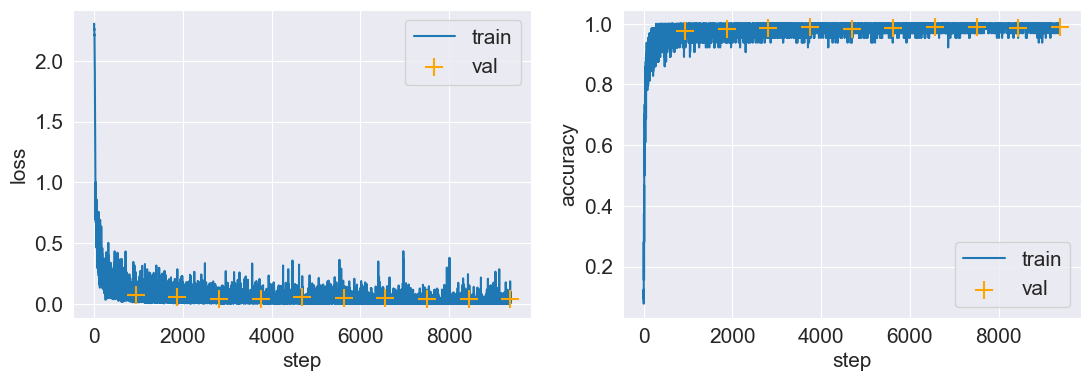

In [27]:
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

history = train_model(model, optimizer, criterion , n_epochs=10, batch_size=64)

In [28]:
print(f'train_loss: {history["train_loss"]}')
print(f'val_loss: {history["val_loss"][-1]}')

print(f'train_accuracy: {history["train_accuracy"]}')
print(f'val_accuracy: {history["val_accuracy"][-1]}')

train_loss: 0.020208110330523638
val_loss: 0.03648906936869025
train_accuracy: 0.9935034648187633
val_accuracy: 0.9894013073979592


In [29]:
def predict(model):
    X, y, logit = [], [], []
    model.eval()
    for batch_num, (x_batch, y_batch) in enumerate(val_loader):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        with torch.no_grad():
            logits = model(x_batch)

        X.extend(x_batch.cpu().numpy()) # это плохо!
        y.extend(y_batch.cpu().numpy())
        logit.extend(torch.max(logits, 1)[1].data.cpu().numpy())
    return np.array(X), np.array(y), np.array(logit)

In [30]:
X_test, y_test, logit = predict(model)
errors = y_test != logit

X_err = X_test[errors]
y_err = y_test[errors]
y_pred_err = logit[errors]

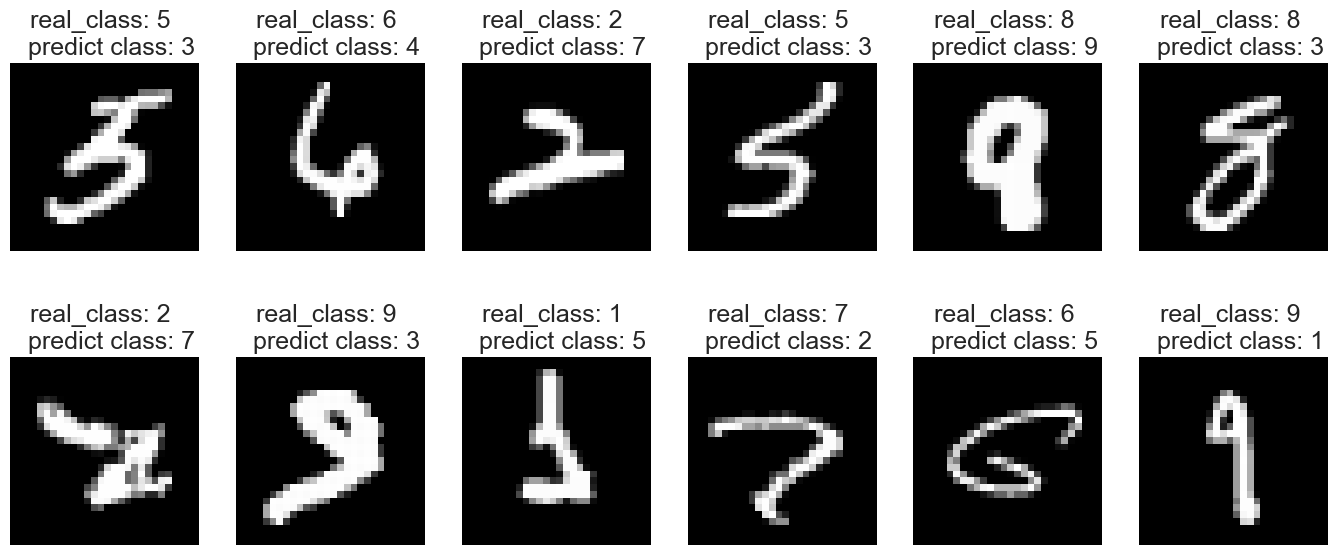

In [31]:
cols = 6
rows = 2
fig = plt.figure(figsize=(3 * cols - 1, 4 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_err))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(np.transpose(X_err[random_index], (1, 2, 0)), cmap='gray')
        ax.set_title('real_class: {} \n  predict class: {}'.format(y_err[random_index], y_pred_err[random_index]))
plt.show()

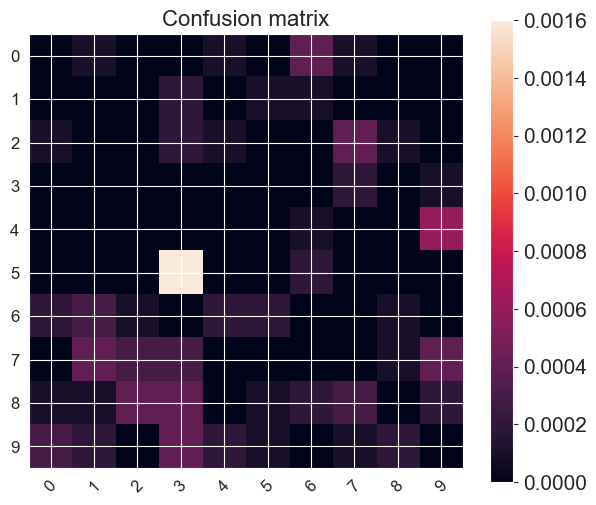

In [32]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, logit, normalize='all')
cm = cm - np.eye(10)*cm.diagonal()

plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(cm)
plt.xticks(np.arange(10), np.arange(10), rotation=45, fontsize=12)
plt.yticks(np.arange(10), np.arange(10), fontsize=12)
plt.colorbar();

In [33]:
X_emb = []
y_test = []

for batch_num, (batch_image, batch_label) in enumerate(val_loader):
    batch_image = batch_image.to(device, non_blocking=True)
    batch_label = batch_label.to(device, non_blocking=True)

    with torch.no_grad():
        X_emb.extend(model.get_embedding(batch_image).cpu().numpy())
    y_test.extend(batch_label.cpu().numpy())

X_emb = np.array(X_emb)
y_test = np.array(y_test)
X_emb.shape

(10000, 90)

Text(0.5, 1.0, 'MNIST t-SNE projection')

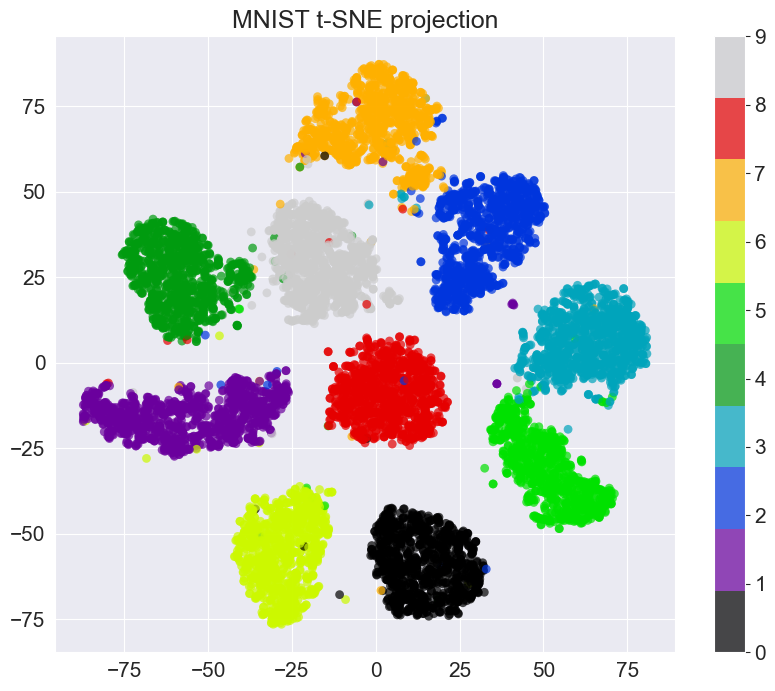

In [34]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_emb)
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_test,
            edgecolors='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))

plt.colorbar()
plt.title('MNIST t-SNE projection')